# LSN Exercise 10

In the same framework of the **Exercise 9**, we are going to implement a **Simulated Annealing (SA)** algorithm to solve again the **Travel Salesman Problem (TSP)** for the same configuration of cities. In addition, we are going to parallelize the **GA** of the previous exercise using **MPI libraries**, performing 4 independet searches of the optimal path over 4 different parallel processes, called *continents*, exchanging information through the best individuals.

In [1]:
# Settings and libraries:

import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)

# Input functions:

def Read(filename):
    with open(filename) as f:
        vector = [float(i) for i in f.read().splitlines()]
    return vector

# ------------------------------------------------------------

def Read_2_col(filename):
    
    a = []
    b = []
    
    with open(filename) as f:
        data = f.read().splitlines()
    
    for i in range(len(data)):
        data[i] = data[i].split()
        a.append(float(data[i][0]))
        b.append(float(data[i][1]))

    return a, b

# --------------------------------------------

## 10.1 TSP class and SA

We kept the same data-structure, methods and functions of the **Excercise 9**, i.e. the `TSP.h` and `TSP.cpp` files remain unchanged. In the *main code* we implemented the **SA algorithm**, following these steps:

- Set the number cities and create a first individual of the same size, called `Initial`;
- Save the initial configuration of cities in `Initial` and print it in `Initial.conf`;
- Define the *annealing schedule*, setting the starting temperature $T_{max}$, the cooling limit $T_{min}$, the cooling scale factor $scale$ and the number of steps for each temperature, $n_{step}$. Every new temperature is decreased by $scale$ times the previous one;
- For every temperature in the cicle define the *inverse temperature* $\beta = \frac{1}{T}$;
- Perform the following steps $n_{step}$ times for each temperature:

  - Save the old configuration in the new one;
  - Perform every tipe of mutation, each with the same probability $p = 25\%$;
  - Compute the cost function for the old configuration and the for the new one;
  - Accept the new configuration with probability proportional to the *Boltzmann weight*: $exp(-\beta(cost_{new} - cost_{old}))$;
  - If accepted, save the new configuration in the old one and store the quadratic distance of the new configuration;
  - If not, store the quadratic distance of the old configuration.
  
For both configurations we used the following values:

- *starting temperature*: $T_{max} = 100.0$;
- *cooling limit*: $T_{min} = 0.001$;
- *cooling scale factor*: $scale = \frac{T_{max}}{1000}$;
- *number of steps*: $n_{step} = 10^4$. 	

## 10.2 Circumference configuration

We present our results for $32$ cities randomly placed **on a circumference of unitary radius**. 

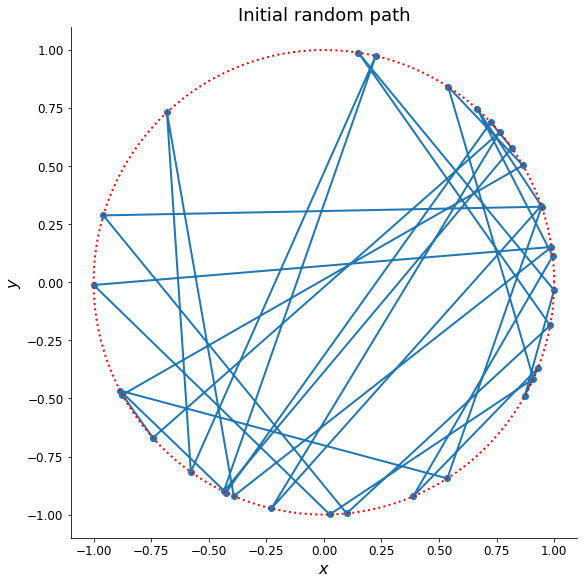

In [2]:
# Initial path with closure
x, y = Read_2_col("Circ/Initial.conf")
x.append(x[0])
y.append(y[0])

# Circumference
theta = np.linspace(0,2*np.pi,1000)
x_c = np.cos(theta)
y_c = np.sin(theta)

FIG_SIZE = (8,8)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(x, y, marker='o')
plt.plot(x_c, y_c, linestyle='dotted', color='red')
plt.title("Initial random path")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

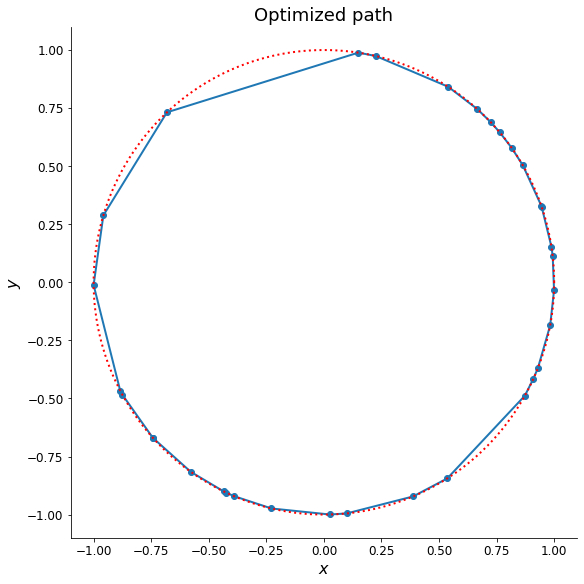

In [3]:
# Optimized path with closure
x, y = Read_2_col("Circ/Best.conf")
x.append(x[0])
y.append(y[0])

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(x, y, marker='o')
plt.plot(x_c, y_c, linestyle='dotted', color='red')
plt.title("Optimized path")
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.show()

------------------------------
Number of cooling steps =  110
------------------------------


/home/simone/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


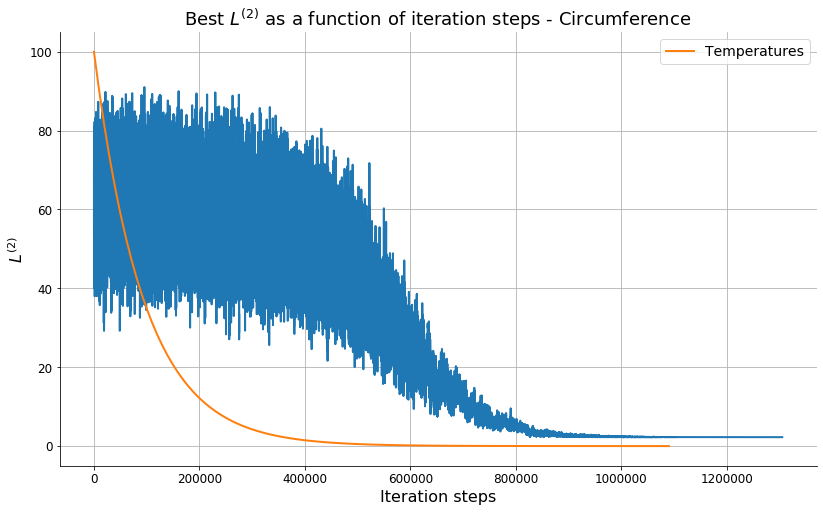

-----------------------------------------------------------------------
The best quadratic distance for the given configuration is: 2.26218
-----------------------------------------------------------------------


In [4]:
# Steps for each new temperature:
n_step = 10**4

L_best = Read("Circ/Distance.best")
temp = Read("Circ/Temperatures.dat")
N = [i for i in range(len(L_best))]
M = [n_step*i for i in range(len(temp))]

# Cooling steps:

print("------------------------------")
print("Number of cooling steps = ", len(temp))
print("------------------------------")

SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, L_best)
plt.plot(M, temp, label='Temperatures')
plt.title("Best $L^{(2)}$ as a function of iteration steps - Circumference")
plt.xlabel("Iteration steps")
plt.ylabel("$L^{(2)}$")
plt.legend()
plt.grid()
plt.show()

# Best path cost
print("-----------------------------------------------------------------------")
print("The best quadratic distance for the given configuration is:", L_best[-1])
print("-----------------------------------------------------------------------")

The wider gap in the first part of the search (high temperaures range) and the gradual symmetrical thinning in the values of $L^{(2)}$ as the temperature drops down, is analogous to what we would expect for the energy values of a real physical system cooling down: hence the name of *simulated annealing*. 

## 10.3 Square configuration

We present our results for $32$ cities randomly placed **inside a square of unitary side length**. 

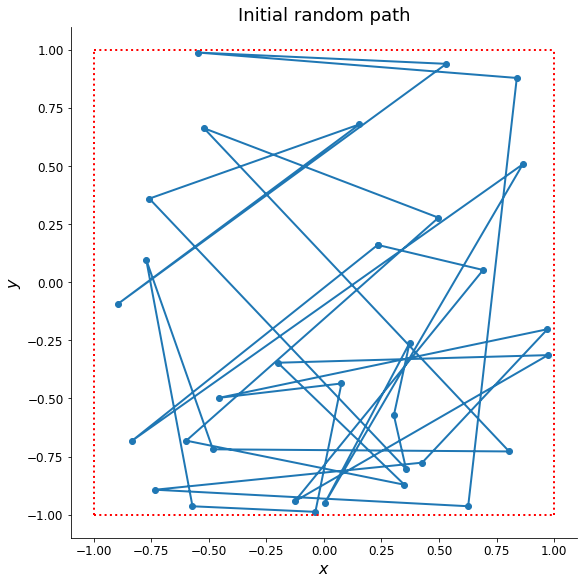

In [5]:
# Initial path with closure
x, y = Read_2_col("Square/Initial.conf")
x.append(x[0])
y.append(y[0])

# Square
x_left = [-1 for i in range(1000)]
x_right = [1 for i in range(1000)]
y_up = x_right
y_down = x_left
line = np.linspace(-1,1,1000)

FIG_SIZE = (8,8)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(x, y, marker='o')
plt.plot(x_left, line, linestyle='dotted', color='red')
plt.plot(x_right, line, linestyle='dotted', color='red')
plt.plot(line, y_up, linestyle='dotted', color='red')
plt.plot(line, y_down, linestyle='dotted', color='red')
plt.title("Initial random path")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

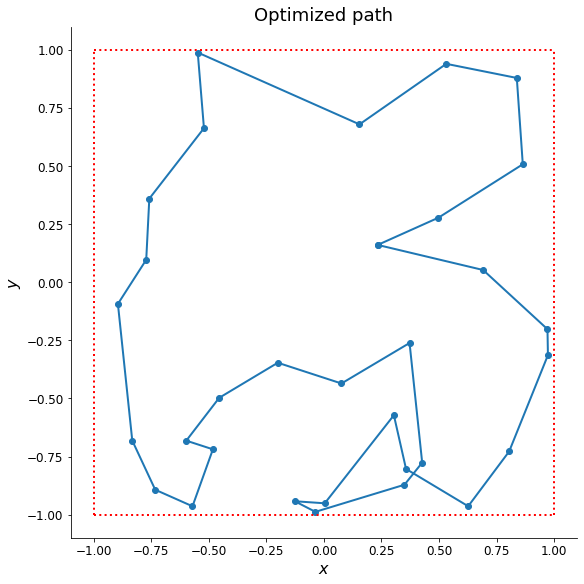

In [6]:
# Optimized path with closure
x, y = Read_2_col("Square/Best.conf")
x.append(x[0])
y.append(y[0])

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(x, y, marker='o')
plt.plot(x_left, line, linestyle='dotted', color='red')
plt.plot(x_right, line, linestyle='dotted', color='red')
plt.plot(line, y_up, linestyle='dotted', color='red')
plt.plot(line, y_down, linestyle='dotted', color='red')
plt.title("Optimized path")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

------------------------------
Number of cooling steps =  110
------------------------------


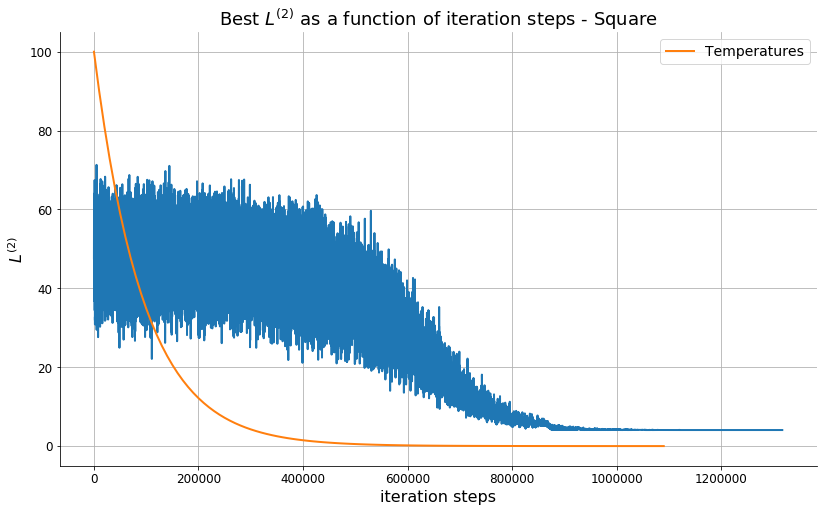

-----------------------------------------------------------------------
The best quadratic distance for the given configuration is: 4.07119
-----------------------------------------------------------------------


In [7]:
L_best = Read("Square/Distance.best")
temp = Read("Square/Temperatures.dat")
N = [i for i in range(len(L_best))]
M = [n_step*i for i in range(len(temp))]

# Cooling steps:

print("------------------------------")
print("Number of cooling steps = ", len(temp))
print("------------------------------")

SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, L_best)
plt.plot(M, temp, label='Temperatures')
plt.title("Best $L^{(2)}$ as a function of iteration steps - Square")
plt.xlabel("iteration steps")
plt.ylabel("$L^{(2)}$")
plt.legend()
plt.grid()
plt.show()

# Best path cost
print("-----------------------------------------------------------------------")
print("The best quadratic distance for the given configuration is:", L_best[-1])
print("-----------------------------------------------------------------------")

The results obtained are very similar to those of the GA approach, but *the GA stil performs better*, because:
- The computational effort is lower: in the square configuration case we used $n_{gen} \times n_{step} = n_{gen} \times \frac{n_{ind}}{2} = 500 \times 250 = 1.25 \times 10^5$ total MC steps, to be compared with $n_{cool} \times n_{step} = 110 \times 10^4 = 1.1 \times 10^6$ MC steps;
- The GA was able to find a shorter path for the square configuration.

## 10.4 MPI parallelization

ESERCIZIO DA SVOLGERE